In [122]:
!pip install -Uqq pyts fastbook binance-connector pandas_ta

In [123]:
# Import necessary libraries
import datetime as dt
import os
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import pandas as pd
import pandas_ta as ta
import pywt
import pywt.data
import re
from pyts.image import GramianAngularField
from PIL import Image as im
from binance.spot import Spot
%matplotlib inline 

import fastbook
fastbook.setup_book()
from fastbook import *
import matplotlib.image

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [124]:
#pywt.wavelist('sym')

In [125]:
SYMBOL = 'BTCUSDT'
INTERVAL = '1m'
INPUT_SIZE = 30
RAW_INPUT_SIZE = 100
THRESHOLD = 0.97
TRADING_PERCENT = 0.1
INITIAL_USD_BALANCE = 1000
STOP_PROFIT = 0.004
STOP_LOSS = 0.004
ORDER_LIFE = 5

In [126]:
def to_dataframe(data):
   np_data = np.array(data)
   df = pd.DataFrame(data=np_data[:, 1:6],
                     index=np_data[:, 0],
                     columns=np_data[0, 1:6])
   df.columns = ['open', 'high', 'low', 'close', 'volume']
   df['open'] = pd.to_numeric(df['open'])
   df['high'] = pd.to_numeric(df['high'])
   df['low'] = pd.to_numeric(df['low'])
   df['close'] = pd.to_numeric(df['close'])
   df['volume'] = pd.to_numeric(df['volume'])


In [127]:
rest_client = Spot()
START_TIME = 0
def prepare_dataset():
    first_data = rest_client.klines(SYMBOL, INTERVAL, limit=500)
    df = to_dataframe(first_data)
    startTime = 4
    #while endTime > START_TIME:
    #    data = rest_client.klines(SYMBOL, INTERVAL, limit=500)

In [128]:
wavelet_type = 'sym15'
w = pywt.Wavelet(wavelet_type)
def denoise(data):
    if len(data) > 0:
        maxlev = pywt.dwt_max_level(len(data), w.dec_len)
        coeffs = pywt.wavedec(data, wavelet_type, level=maxlev)
        coeffs[-1] = np.zeros_like(coeffs[-1])
        datarec = pywt.waverec(coeffs, wavelet_type)
        return datarec
    else:
        return data

In [129]:
BTC = pd.read_csv("../input/bitcoin-btcusdt/Bitcoin_BTCUSDT.csv")
df = BTC.iloc[-10000:].reset_index(drop=True)

In [130]:

def calc_label(dataset, position):
    price = dataset['close'].to_numpy()[position]
    stop_loss = STOP_LOSS * price
    stop_profit = STOP_PROFIT * price
    label = "wait"
    bearish_stop_loss = price + stop_loss
    bearish_stop_profit = price - stop_profit
    bullish_stop_loss = price - stop_loss
    bullish_stop_profit = price + stop_profit
    for i in range(1, ORDER_LIFE+1):
        max_price = dataset['high'].to_numpy()[position+i]
        low_price = dataset['low'].to_numpy()[position+i]
        if low_price > bullish_stop_loss:
            if max_price >= bullish_stop_profit:
                label = "buy"
                break
        else:
            break
    for i in range(1, ORDER_LIFE+1):
        max_price = dataset['high'].to_numpy()[position+i]
        low_price = dataset['low'].to_numpy()[position+i]
        if max_price < bearish_stop_loss:
            if low_price <= bearish_stop_profit:
                label = "sell"
                break
        else:
            break
    return label
        
       

    

In [131]:
L = len(df['close'])
df_labels = [None]*L
for i in range(0, L-ORDER_LIFE):
    df_labels[i] = calc_label(df, i)

df_labeled_raw = df.copy()
df_labeled_raw['label'] = df_labels

In [132]:
df_labeled_raw[150:300]

,timestamp,open,high,low,close,volume,label
150,2022-05-16 16:16:00,29395.11,29395.12,29353.08,29363.26,65.31633,wait
151,2022-05-16 16:17:00,29363.25,29395.12,29321.99,29343.82,82.56491,buy
152,2022-05-16 16:18:00,29343.82,29448.89,29315.24,29448.81,157.70268,wait
153,2022-05-16 16:19:00,29448.81,29470.58,29421.80,29449.74,63.57436,wait
154,2022-05-16 16:20:00,29449.99,29478.43,29434.47,29449.06,53.66338,wait
...,...,...,...,...,...,...,...
295,2022-05-16 18:41:00,29897.77,29902.35,29872.71,29887.70,22.79386,wait
296,2022-05-16 18:42:00,29887.69,29914.69,29887.69,29903.35,23.05728,wait
297,2022-05-16 18:43:00,29903.35,29924.94,29903.34,29904.90,40.32597,wait
298,2022-05-16 18:44:00,29904.91,29904.91,29860.00,29865.40,81.85236,wait


In [133]:


df = df_labeled_raw.iloc[:-ORDER_LIFE]

In [ ]:
DS_LENGTH = len(df['close'])
df

In [ ]:
input_open = [None]*DS_LENGTH
input_high = [None]*DS_LENGTH
input_low = [None]*DS_LENGTH
input_close = [None]*DS_LENGTH
input_volume = [None]*DS_LENGTH
input_timestamp = [None]*DS_LENGTH
for i in range(0, DS_LENGTH):
    input_open[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].open
    input_high[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].high
    input_low[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].low
    input_close[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].close
    input_volume[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].volume
    input_timestamp[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].timestamp

df['input_open'] = input_open
df['input_high'] = input_high
df['input_low'] = input_low
df['input_close'] = input_close
df['input_volume'] = input_volume
df['input_timestamp'] = input_timestamp

df = df.iloc[RAW_INPUT_SIZE:].reset_index(drop=True)
input_open[120].plot.line()


<Axes: >

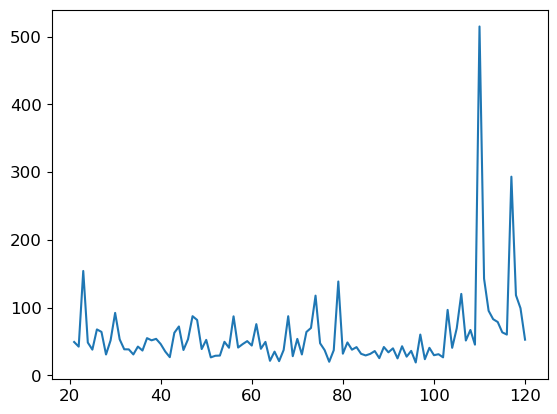

In [136]:
input_volume[120].plot.line()


In [137]:
df = df[df['label'] != 'wait'].reset_index(drop=True)

In [ ]:
DS_LENGTH = len(df['close'])
denoised_input_open = [None]*DS_LENGTH
denoised_input_high = [None]*DS_LENGTH
denoised_input_low = [None]*DS_LENGTH
denoised_input_close = [None]*DS_LENGTH
denoised_input_volume = [None]*DS_LENGTH
input_timestamp = [None]*DS_LENGTH
for i in range(0, DS_LENGTH):
    input_open[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].open
    input_high[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].high
    input_low[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].low
    input_close[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].close
    input_volume[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].volume
    input_timestamp[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].timestamp

df['input_open'] = input_open
df['input_high'] = input_high
df['input_low'] = input_low
df['input_close'] = input_close
df['input_volume'] = input_volume
df['input_timestamp'] = input_timestamp


In [140]:
df_2_cat['macd'][120]

,close,timestamp
timestamp,,
NaT,29975.278743,NaN
NaT,30000.003362,NaN
NaT,30029.976749,NaN
NaT,30046.291663,NaN
NaT,30039.212941,NaN
...,...,...
NaT,30258.828359,NaN
NaT,30255.889285,NaN
NaT,30269.354028,NaN


In [141]:
gaf_transformer = GramianAngularField(method='difference', image_size=INPUT_SIZE)
df_gaf_input_close = [None]*DS_LENGTH
df_gaf_input_open = [None]*DS_LENGTH
df_gaf_input_high = [None]*DS_LENGTH
df_gaf_input_low = [None]*DS_LENGTH
df_gaf_input_volume = [None]*DS_LENGTH
for i in range(0, DS_LENGTH):
    if len(df_2_cat['denoised_open'][i]) > 0:
        df_gaf_input_open[i] = gaf_transformer.fit_transform(df_2_cat['denoised_open'][i][-INPUT_SIZE:].reshape(1, -1))
        df_gaf_input_high[i] = gaf_transformer.fit_transform(df_2_cat['denoised_high'][i][-INPUT_SIZE:].reshape(1, -1))
        df_gaf_input_low[i] = gaf_transformer.fit_transform(df_2_cat['denoised_low'][i][-INPUT_SIZE:].reshape(1, -1))
        df_gaf_input_close[i] = gaf_transformer.fit_transform(df_2_cat['denoised_close'][i][-INPUT_SIZE:].reshape(1, -1))
        df_gaf_input_volume[i] = gaf_transformer.fit_transform(df_2_cat['denoised_volume'][i][-INPUT_SIZE:].reshape(1, -1))

In [142]:
df_2_cat['gaf_open'] = df_gaf_input_open
df_2_cat['gaf_high'] = df_gaf_input_high
df_2_cat['gaf_low'] = df_gaf_input_low
df_2_cat['gaf_close'] = df_gaf_input_close
df_2_cat['gaf_volume'] = df_gaf_input_volume

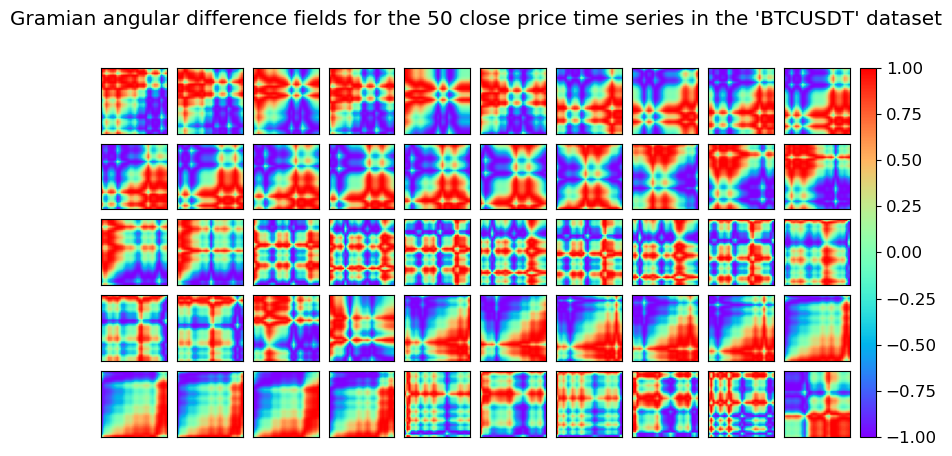

In [143]:
fig = plt.figure(figsize=(10, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 10), axes_pad=0.1, share_all=True,
                 cbar_mode='single')
for i, ax in enumerate(grid):
    image_item = ax.imshow(df_2_cat['gaf_open'].to_numpy()[i+10].squeeze(), cmap='rainbow', origin='lower', vmin=-1., vmax=1.)
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
plt.colorbar(image_item, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)
fig.suptitle("Gramian angular difference fields for the 50 close price time series in the "
             "'BTCUSDT' dataset")
plt.show()

In [144]:
df_train = df_2_cat


In [145]:
images_path = '/kaggle/working/images/'
if not os.path.exists(images_path):
   os.makedirs(images_path)

In [146]:
files = get_image_files(images_path)
for f in files:
    os.remove(f)

In [147]:
L = len(df_train['close'])
for i in range(0, L):
    i_open = df_train['gaf_open'].to_numpy()[i].squeeze()
    i_high = df_train['gaf_high'].to_numpy()[i].squeeze()
    i_low = df_train['gaf_low'].to_numpy()[i].squeeze()
    i_close = df_train['gaf_close'].to_numpy()[i].squeeze()
    i_volume = df_train['gaf_volume'].to_numpy()[i].squeeze()
    row1 = np.concatenate([i_open, i_high, i_low])
    row2 = np.concatenate([i_close, i_volume, i_volume])
    data = np.concatenate([row1, row2], axis=1)
    label = df_train['label'].to_numpy()[i]
    matplotlib.image.imsave(images_path + label + '_' + str(i) + '.png', data)

In [148]:
files = get_image_files(images_path)

In [149]:
files

(#851) [Path('/kaggle/working/images/sell_227.png'),Path('/kaggle/working/images/buy_830.png'),Path('/kaggle/working/images/sell_330.png'),Path('/kaggle/working/images/buy_210.png'),Path('/kaggle/working/images/sell_604.png'),Path('/kaggle/working/images/sell_392.png'),Path('/kaggle/working/images/sell_829.png'),Path('/kaggle/working/images/sell_2.png'),Path('/kaggle/working/images/buy_506.png'),Path('/kaggle/working/images/buy_186.png')...]

In [150]:
pat = r'^(.*)_\d+.png'

In [151]:

dls = ImageDataLoaders.from_name_re(images_path, files, pat)

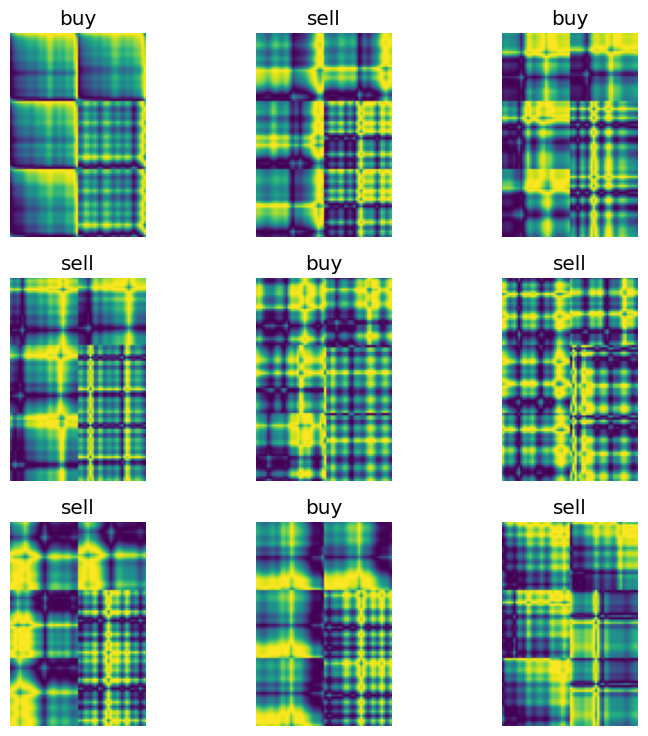

In [152]:
dls.show_batch()

In [153]:
learn = vision_learner(dls, resnet101, metrics=error_rate) # resnet152

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [154]:
#learn.lr_find()

In [155]:
learn.fine_tune(10, 0.0002290867705596611)

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

In [ ]:
#learn.show_results()

In [ ]:
#learn.predict(files[0])

In [ ]:
learn.export(fname='/kaggle/working/model.pkl')
